<a href="https://colab.research.google.com/github/Wanita-8943/efficientnet_keras_transfer_learning/blob/master/%E0%B9%82%E0%B8%AD%E0%B9%80%E0%B8%84_2M_MAE_dataframe_Male_500.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import shutil

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import os
import glob
import shutil
import sys
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline

In [4]:
batch_size = 16
width = 150
height = 150
epochs = 500
NUM_TRAIN = 1425
NUM_TEST = 475
dropout_rate = 0.2
input_shape = (height, width, 3)

In [5]:
#ดึงข้อมูลใน Github มาใช้
import os
%cd /content
if not os.path.isdir("efficientnet_keras_transfer_learning"):
 !git clone https://github.com/Wanita-8943/efficientnet_keras_transfer_learning
%cd efficientnet_keras_transfer_learning/

/content
Cloning into 'efficientnet_keras_transfer_learning'...
remote: Enumerating objects: 801, done.
remote: Counting objects: 100% (323/323), done.
remote: Compressing objects: 100% (136/136), done.
remote: Total 801 (delta 231), reused 248 (delta 187), pack-reused 478
Receiving objects: 100% (801/801), 13.50 MiB | 6.85 MiB/s, done.
Resolving deltas: 100% (471/471), done.
/content/efficientnet_keras_transfer_learning


In [6]:
# Options: EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3
# Higher the number, the more complex the model is.
from efficientnet import EfficientNetB0 as Net
from efficientnet import center_crop_and_resize, preprocess_input

In [7]:
base_dir = '/content/drive/MyDrive/TVT_Male125'
os.makedirs(base_dir, exist_ok=True)

# Directories for our training,
# validation and test splits
train_dir = os.path.join(base_dir, 'train')
os.makedirs(train_dir, exist_ok=True)
validation_dir = os.path.join(base_dir, 'validation')
os.makedirs(validation_dir, exist_ok=True)
test_dir = os.path.join(base_dir, 'test')
os.makedirs(test_dir, exist_ok=True)

#load model

In [8]:
import sys
sys.path.append('/content/drive/MyDrive/cut_panoramic/Model/1_New_MAE_Flimpano_Male18_500.h5')

from efficientnet.layers import Swish, DropConnect
from efficientnet.model import ConvKernalInitializer
from tensorflow.keras.utils import get_custom_objects

get_custom_objects().update({
    'ConvKernalInitializer': ConvKernalInitializer,
    'Swish': Swish,
    'DropConnect':DropConnect
})

In [9]:
#load model 
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/cut_panoramic/Model/1_New_MAE_Flimpano_Male18_500.h5')
height = width = model.input_shape[1]

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b0 (Functional  (None, 5, 5, 1280)       4049564   
 )                                                               
                                                                 
 gap (GlobalMaxPooling2D)    (None, 1280)              0         
                                                                 
 dropout_out (Dropout)       (None, 1280)              0         
                                                                 
 fc_out (Dense)              (None, 19)                24339     
                                                                 
 dense (Dense)               (None, 1)                 20        
                                                                 
Total params: 4,073,923
Trainable params: 24,359
Non-trainable params: 4,049,564
_________________________________________

In [12]:
df = pd.read_csv (r'/content/drive/MyDrive/cut_panoramic/Data/New_Data_Male125.csv')
df

,Fig_Age,Fig_Person_Sex,Age(year),Class,Class_Re,Filename,Path_filename,Sex,Floder
0,1,1,7,Y07M,0,VV03.jpg,/content/drive/My Drive/TVT_Male125/train/Y07M...,เพศชาย,Both
1,2,1,7,Y07M,0,Flip_VV03.jpg,/content/drive/My Drive/TVT_Male125/train/Y07M...,เพศชาย,Both
2,3,2,7,Y07M,0,VV04.jpg,/content/drive/My Drive/TVT_Male125/train/Y07M...,เพศชาย,Both
3,4,2,7,Y07M,0,Flip_VV04.jpg,/content/drive/My Drive/TVT_Male125/train/Y07M...,เพศชาย,Both
4,5,3,7,Y07M,0,VV05.jpg,/content/drive/My Drive/TVT_Male125/train/Y07M...,เพศชาย,Both
...,...,...,...,...,...,...,...,...,...
2370,121,77,25,Y25M,18,Flip_J463.jpg,/content/drive/My Drive/TVT_Male125/test/Y25M/...,เพศชาย,Both
2371,122,78,25,Y25M,18,J464.jpg,/content/drive/My Drive/TVT_Male125/test/Y25M/...,เพศชาย,Both
2372,123,78,25,Y25M,18,Flip_J464.jpg,/content/drive/My Drive/TVT_Male125/test/Y25M/...,เพศชาย,Both
2373,124,79,25,Y25M,18,J465.jpg,/content/drive/My Drive/TVT_Male125/test/Y25M/...,เพศชาย,Both


In [13]:
train = df[df['Fig_Age'].between(1,75)]
val = df[df['Fig_Age'].between(76,100)]

In [14]:
DATA_PATH = "/content/drive/My Drive/TVT_Male125"
os.chdir(DATA_PATH)
train_dir = os.path.join(DATA_PATH, 'train')
print(train_dir)
validation_dir = os.path.join(DATA_PATH, 'validation')
print(validation_dir)

/content/drive/My Drive/TVT_Male125/train
/content/drive/My Drive/TVT_Male125/validation


In [15]:
# Train ด้วย ImageDataGenerator ของ Keras ซึ่งจะเพิ่มข้อมูลเสริมระหว่างการฝึกเพื่อลดโอกาสเกิด overfitting
#overfitting เกิดจากข้อมูลที่ซับซ้อนกันเกินไป
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255, #โมเดลส่วนใหญ่ต้องใช้ RGB ในช่วง 0–1
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
        dataframe = train,
        directory = train_dir,
        x_col = 'Path_filename',
        y_col = 'Class_Re',
        class_mode = 'other',
        target_size=(height, width),
        batch_size=batch_size)

validation_generator = test_datagen.flow_from_dataframe(
        dataframe = val,
        directory = validation_dir,
        x_col = 'Path_filename',
        y_col = 'Class_Re',
        class_mode = 'other',
        target_size=(height, width),
        batch_size=batch_size)

Found 1425 validated image filenames.
Found 475 validated image filenames.


In [16]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch= NUM_TRAIN //batch_size,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps= NUM_TEST //batch_size,
      verbose=1,
      use_multiprocessing=True,
      workers=4)

<ipython-input-16-caa7b37242a8>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/500
89/89 [==============================] - 409s 4s/step - loss: 10.5178 - mae: 2.5802 - val_loss: 11.1665 - val_mae: 2.6332
Epoch 2/500
89/89 [==============================] - 26s 287ms/step - loss: 10.7724 - mae: 2.6373 - val_loss: 11.6726 - val_mae: 2.6325
Epoch 3/500
89/89 [==============================] - 26s 286ms/step - loss: 10.9889 - mae: 2.6288 - val_loss: 11.0690 - val_mae: 2.6095
Epoch 4/500
89/89 [==============================] - 24s 267ms/step - loss: 10.4445 - mae: 2.5797 - val_loss: 11.5704 - val_mae: 2.6528
Epoch 5/500
89/89 [==============================] - 25s 273ms/step - loss: 9.5025 - mae: 2.4596 - val_loss: 11.6456 - val_mae: 2.6909
Epoch 6/500
89/89 [==============================] - 19s 213ms/step - loss: 10.5771 - mae: 2.5532 - val_loss: 12.0857 - val_mae: 2.7004
Epoch 7/500
89/89 [==============================] - 25s 277ms/step - loss: 10.9902 - mae: 2.6308 - val_loss: 10.0856 - val_mae: 2.5076
Epoch 8/500
89/89 [==============================] 

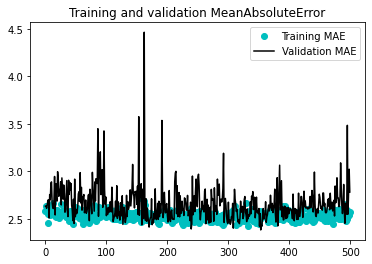

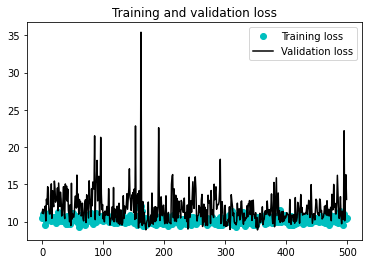

In [17]:
loss = history.history['loss']
val_loss = history.history['val_loss']
mae = history.history['mae']
val_mae = history.history['val_mae']


epochs_x = range(len(loss))


plt.plot(epochs_x, mae, 'co', label='Training MAE')
plt.plot(epochs_x, val_mae, 'k', label='Validation MAE')
plt.title('Training and validation MeanAbsoluteError')
plt.legend()

plt.figure()
plt.plot(epochs_x, loss, 'co', label='Training loss')
plt.plot(epochs_x, val_loss, 'k', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#Download the model

In [18]:
os.makedirs('/content/drive/My Drive/cut_panoramic/Model', exist_ok=True)
model.save('/content/drive/My Drive/cut_panoramic/Model/2_New_MAE_Flimpano_Male18_500.h5')

In [ ]:
# from google.colab import files
# files.download('/content/drive/My Drive/cut_panoramic/Model/2.2_รอบที่2_Flimpano_Male125_250.h5')